# 建筑图像检测

**同学们，我们将使用卫星图像来检测建筑物。这是一个经典的二分类分割问题。**

![jpg](../data/image/%E5%BB%BA%E7%AD%91%E6%A3%80%E6%B5%8B.jpg)

## 数据

**输入数据是 RGB 卫星图像。输出是二值图像。非建筑物的像素值为 0，建筑物的像素值为 1。**
<div style="display:flex;">
    <div style="text-align:center;">
        <img src="../data/image/image.png" style="width:400px; height:400px; margin-bottom:10px;">
        <p>Image</p>
    </div>
    <div style="text-align:center; margin-left:20px;">
        <img src="../data/image/label.png" style="width:400px; height:400px; margin-bottom:10px;">
        <p>Label</p>
    </div>
</div>

## 导入包

In [15]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#一个Python的图像处理库
from PIL import Image 

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Conv2DTranspose,Concatenate,Dropout
#Conv2D：二维卷积层，用于处理图像数据。它通过在输入数据上滑动卷积核（过滤器），提取特征或执行图像过滤。
#MaxPooling2D：二维最大池化层，用于减小特征图的尺寸，同时保留重要的特征。
#Conv2DTranspose：二维卷积转置层，也称作逆卷积或脱卷积。它通常用于上采样，即增加特征图的尺寸
#Concatenate：连接层，用于沿特定轴将一组输入合并。
#Dropout：丢弃层，用于正则化模型以防止过拟合

## 数据处理

In [16]:
#`glob`模块来搜索匹配特定模式的文件路径，然后将这些路径排序并存储在列表中。
train_x = sorted(glob.glob('../data/train/*_image.tif'))
train_y = sorted(glob.glob('../data/train/*_label.tif'))
test_x = sorted(glob.glob('../data/test/*_image.tif'))
test_y = sorted(glob.glob('../data/test/*_label.tif'))

print(len(train_x),len(test_x))

70 30


In [17]:
#将图片转换为数组---train_data
#创建空矩阵
train_xx = np.zeros((70,128,128,3))
train_yy = np.zeros((70,128,128,1))

#写循环
for i,(img,mask) in enumerate(zip(train_x,train_y)):
    img = Image.open(img)
    np_img = np.array(img)
    train_xx[i] = np_img
    
    mask = Image.open(mask)
    np_mask = np.array(mask).reshape(128, 128, 1)
    train_yy[i] = np_mask 
    

In [18]:
#将图片转换为数组---test_data
test_xx = np.zeros((30,128,128,3))
test_yy = np.zeros((30,128,128,1))

for i, (img, mask) in enumerate(zip(test_x, test_y)):
    
  img = Image.open(img)
  np_img = np.array(img)
  test_xx[i] = np_img 

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask 

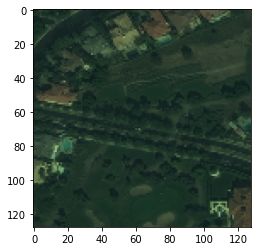

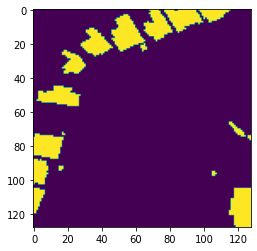

In [19]:
#尝试绘制一下它们
plt.imshow(test_xx[20,:,:,:].astype('uint8'))
plt.show()
plt.imshow(test_yy[20,:,:,:].astype('uint8'))
plt.show()

## 保存numpy数组

In [20]:
train_xx.shape

(70, 128, 128, 3)

In [21]:
np.save('train_xx.npy', train_xx)
np.save('train_yy.npy', train_yy)
np.save("test_xx.npy", test_xx)
np.save("test_yy.npy", test_yy)

## U-net模型
<img src="../data/image/u-net.jpg" width="900" height="600">


In [29]:
'''输入层'''
x_in= Input(shape=(128,128,3))

'''Encoder'''
x_temp = Conv2D(32,(3,3),activation='relu',padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32,(3,3),activation='relu',padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)

x_temp = Conv2D(32,(3,3),activation='relu',padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32,(3,3),activation='relu',padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)

x_temp = Conv2D(64,(3,3),activation='relu',padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64,(3,3),activation='relu',padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)

x_temp = Conv2D(64,(3,3),activation='relu',padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(64,(3,3),activation='relu',padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64,(3,3),activation='relu',padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2DTranspose(64,(3,3),activation='relu',strides=(2,2),padding='same')(x_temp)
x_temp = Concatenate()([x_temp,x_skip3])

x_temp = Conv2DTranspose(64,(3,3),activation='relu',padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2DTranspose(64,(3,3),activation='relu',strides=(2,2),padding='same')(x_temp)
x_temp = Concatenate()([x_temp,x_skip2])

x_temp = Conv2DTranspose(32,(3,3),activation='relu',padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2DTranspose(64,(3,3),activation='relu',strides=(2,2),padding='same')(x_temp)
x_temp = Concatenate()([x_temp,x_skip1])

x_temp = Conv2DTranspose(32,(3,3),activation='relu',padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2DTranspose(32,(3,3),activation='relu',padding='same')(x_temp)


'''使用1x1卷积核来实现单通道图像'''
x_temp = Conv2D(32,(1,1),activation='relu',padding='same')(x_temp)
x_temp = Conv2D(32,(1,1),activation='relu',padding='same')(x_temp)
x_out = Conv2D(1,(1,1),activation='sigmoid',padding='same')(x_temp)

"""二分类问题使用得激活函数是：sigmoid"""

model = Model(inputs=x_in,outputs=x_out)

model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_16 (Dropout)           (None, 128, 128, 32  0           ['conv2d_22[0][0]']              
                                )                                                           

In [30]:
#训练模型
history = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=100, batch_size=10, verbose=1)

Epoch 1/100
7/7 [==============================] - 12s 131ms/step - loss: 0.1969 - val_loss: 0.1461
Epoch 2/100
7/7 [==============================] - 0s 63ms/step - loss: 0.1661 - val_loss: 0.1453
Epoch 3/100
7/7 [==============================] - 0s 61ms/step - loss: 0.1476 - val_loss: 0.1316
Epoch 4/100
7/7 [==============================] - 0s 68ms/step - loss: 0.1428 - val_loss: 0.1362
Epoch 5/100
7/7 [==============================] - 0s 64ms/step - loss: 0.1435 - val_loss: 0.1281
Epoch 6/100
7/7 [==============================] - 0s 70ms/step - loss: 0.1361 - val_loss: 0.1176
Epoch 7/100
7/7 [==============================] - 0s 65ms/step - loss: 0.1338 - val_loss: 0.1165
Epoch 8/100
7/7 [==============================] - 0s 69ms/step - loss: 0.1327 - val_loss: 0.1156
Epoch 9/100
7/7 [==============================] - 0s 73ms/step - loss: 0.1294 - val_loss: 0.1126
Epoch 10/100
7/7 [==============================] - 0s 69ms/step - loss: 0.1292 - val_loss: 0.1190
Epoch 11/100
7/7 

## 绘制损失曲线

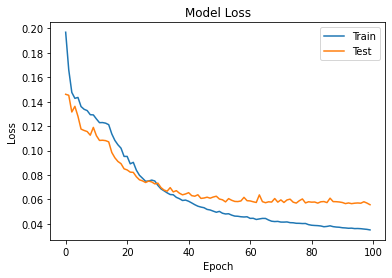

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# 预测

1/1 [==============================] - 0s 31ms/step
(30, 128, 128, 1)


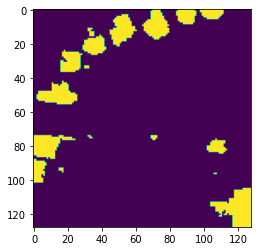

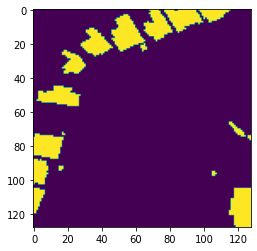

In [34]:
#设定阈值
threshold=0.5

# 预测结果
pred_test = model.predict(test_xx)
pred_test = (pred_test>threshold).astype(np.uint8)
print(pred_test.shape)

#绘制一下 
plt.imshow(pred_test[20,:,:,:].astype('uint8'))
plt.show()
plt.imshow(test_yy[20,:,:,:].astype('uint8'))
plt.show()